# Evolution du bruit médian en France depuis le début de la pandémie

> Ce Notebook présente lévolution du bruit médian en France depuis lde début de l'épidémie

---
## Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings
from scipy import optimize
from scipy.signal import hilbert

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
## Paramètre initiaux

In [2]:
PPSD_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/PPSD"
DRMS_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/DRMS"
MSEED_FOLDER = "/media/flavien/Flavien USB/Stages/noise_data/MSEED"
DATA_FOLDER  = "DATA"
freqs = [(0.01, 0.03), (0.1, 0.25), (0.3, 1), (1, 3), (5, 15), (20, 50)] # Bandes de fréquences à étudier
freq = "5.0-15.0"
freq_str = "5.0-15.0"

tStart = "2020-01-01"
tEnd   = "2021-08-01"

# list_stations = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ", "FR.BRGF.00.HHZ"]
list_stations = np.loadtxt(DATA_FOLDER + "/st_metadata/stations_fr.txt", dtype=str)

In [3]:
tags = {
    "2020-03-17": "LD1", # Lockdown 1
    "2020-05-11": "END LD1", # End lockdown
    "2020-10-30": "LD2", # Lockdown 2
    "2020-12-15": "END LD2", # End lockdown + Curfew 20h
    "2020-12-25": "CHR", # Christmas
    "2021-01-01": "NY", # New Year
    "2021-01-16": "CF18", # Curfew 18h
    "2021-03-20": "CF19", # Curfew 19h
    "2021-04-03": "LD3", # Lockdown 3
    "2021-05-03": "END LD3", # End of certificate
    "2021-05-19": "CF21", # Curfew 21h + Shops open
    "2021-06-09": "CF23", # Curfew 23h + Restaurants open
    "2021-06-30": "END" # End Curfew
}
dates_tags = pd.to_datetime(([key for key in tags.keys()]))
desc_tags = [(value) for value in tags.values()]

---
## Médiane à toutes les stations

#### Calcul de la médiane pour chaque station

On calcul les PPSDs sur l'ensemble des périodes d'un mois (1 mois pendant le confinement, 1 mois hors confinement). Toutes les données sont stockées dans le dictionnaire `ppsds`.

In [4]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [5]:
med_values = []
st_list = []

for j, st_str in tqdm.tqdm(enumerate(list_stations)):
    # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index = pd.to_datetime(dataframe.index)
        dRMS = dataframe.copy()
    except:
        continue
       
    ### Conversion heures locales
    dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()  
        
    ### On garde les données dans la période temporelle qui nous intéresse
    mask_time = (dRMS.index > tStart) & (dRMS.index <= tEnd)
    dRMS = dRMS.loc[mask_time]
    
    ### Récupération du bruit
    dRMS_med = dRMS[freq].between_time("6:00", "18:00").resample("1D").median()
    dRMS_med = dfDates.join(dRMS_med, how='outer')
    
    if False:
        ### Mise en graphique
        color = "#353535"
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.tick_params(direction="in", which="both", top=True, right=True)
        ax.set_title("Frequency band : {}Hz | {}".format(freq_str, st_str))
        ax.plot(dRMS_med*1e9, color=color, lw=2, zorder=3)
        plt.ylim(-1*np.nanquantile(dRMS_med, 0.01)/1e-9, 1.5*np.nanquantile(dRMS_med, 0.99)/1e-9)
        ax.set_xlim([dates[0], dates[-1]])
        ax.set_xlabel("Year 2020")
        ax.set_ylabel("Median displacement [nm]")

        box_txt = dict(boxstyle="square",
                   facecolor='#B7C0D8',
                   edgecolor='none',
                   alpha=0.5)

        for n in range(len(dates_tags)):
            t_search = dates_tags[n]
            desc_search = desc_tags[n]
            t_text = t_search - pd.Timedelta("5 days")
            ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
            ax.text(t_text, -0.8*np.nanquantile(dRMS_med, 0.01)/1e-9, desc_search,
                    color="#2B2B2B", fontsize="medium", rotation=90,
                    ha="center", va="bottom",
                    bbox=box_txt)   # Confinement 1

        plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
        plt.tight_layout()
        folder = "RESULTS/FR/{}/{}Hz".format(st_str, freq_str)
        if not os.path.exists(folder): os.makedirs(folder)
        plt.savefig("{}/ts_day.png".format(folder), dpi=150)
        # plt.show()
        plt.close()
        plt.clf()

    ### Normalisation du bruit
    dRMS_med = dRMS_med[freq].tolist()
    med_values.append(dRMS_med)
    st_list = np.append(st_list, st_str)

147it [00:11, 12.47it/s]


In [6]:
print("Dimensions de la matrice :", np.shape(med_values))

Dimensions de la matrice : (127, 578)


#### Calcul de la médiane de toutes les stations

/home/flavien/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


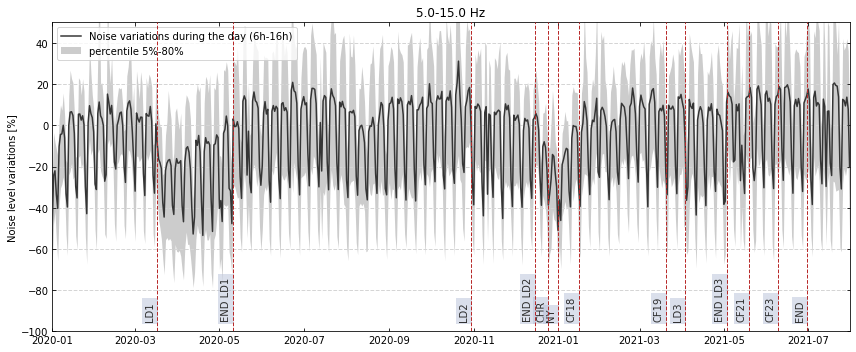

In [7]:
noise_fr = np.zeros(nDays)
norm_period = ["2020-01-15", "2020-03-10"]
t1_i = np.where(dates >= pd.Timestamp(norm_period[0]))[0][0]
t2_i = np.where(dates >= pd.Timestamp(norm_period[1]))[0][0]

st_list_new = []
for i in range(np.shape(med_values)[0]):
    sublist = med_values[i][:]
    noise_med = np.nanmedian(sublist[t1_i:t2_i])
    try:
        newlist = (sublist - noise_med)/noise_med*100
    except:
        continue
    if i == 0: med_var = newlist
    else     : med_var = np.vstack([med_var, newlist])
    st_list_new.append(st_list[i])
    
perc_i = list()  # 5%
perc_f = list()  # 80%

for ii in range(np.shape(med_var)[1]):
    sublist = list()
    for i in range(np.shape(med_var)[0]):
        sublist = np.append(sublist, med_var[i][ii])
    perc_i = np.append(perc_i, np.nanquantile(sublist, 0.05))
    perc_f = np.append(perc_f, np.nanquantile(sublist, 0.8))
    
noise_fr = np.nanmedian(med_var, axis=0)
    
color = "#353535"
fig, ax = plt.subplots(figsize=(12, 5))
ax.tick_params(direction="in", which="both", top=True, right=True)
ax.plot(dates, noise_fr, color=color, lw=1.5, zorder=3, label="Noise variations during the day (6h-16h)")
plt.ylim(3.5 * np.quantile(noise_fr, 0.05), 5 * np.quantile(noise_fr, 0.95))
ax.set_xlim([dates[0], dates[-1]])
ax.set_ylabel("Noise level variations [%]")

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    ax.text(t_text, -95, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1
    
plt.fill_between(dates, perc_i, perc_f,alpha=.25, label="percentile 5%-80%", color=color, lw=0)    
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylim(-100, 50)
plt.legend(loc=2)
plt.title("{} Hz".format(freq_str))
plt.tight_layout()
folder = "RESULTS/FR/all_stations/{}Hz".format(freq_str)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/ts_day.png".format(folder), dpi=150)
plt.show()

In [8]:
noise_all = noise_fr
dates_all = dates

### Jours de la semaine

In [9]:
week = [(0, 'Monday'), (1, 'Tuesday'), (2, 'Wednesday'), (3, 'Thursday'), (4, 'Friday'), (5, 'Saturday'), (6, 'Sunday')]

# On détermine les jours de la semaine de tous les jours étudiés
week_count = {'Monday':[], 'Tuesday':[], 'Wednesday':[], 'Thursday':[], 'Friday':[], 'Saturday':[], 'Sunday':[]}

for iDay in range(len(dates)):
    for iw, weekday in week:
        if dates[iDay].dayofweek==iw:
            week_count[weekday].append(iDay)
            
for key in week_count.keys():
    week_count[key] = np.array(week_count[key])

In [10]:
def enveloppe(x, f):
    lmin = (np.diff(np.sign(np.diff(f))) > 0).nonzero()[0] + 1 
    lmax = (np.diff(np.sign(np.diff(f))) < 0).nonzero()[0] + 1 

    idx_down = lmin[[i+np.argmin(f[lmin[i:i+1]]) for i in range(0,len(lmin), 1)]]
    idx_up = lmax[[i+np.argmax(f[lmax[i:i+1]]) for i in range(0,len(lmax), 1)]]
    
    env_down = np.interp(x, x[idx_down], f[idx_down])
    env_up = np.interp(x, x[idx_up], f[idx_up])
    
    return env_down, env_up

In [11]:
env_up_matrix = np.zeros((129, 82))
env_down_matrix = np.zeros((129, 82))
    
for i in range(np.shape(med_var)[0]):
    sub_list = med_var[i][:]
    env_up_matrix[i][:] = sub_list[week_count['Monday']]
    env_down_matrix[i][:] = sub_list[week_count['Sunday']]

/tmp/ipykernel_31109/4127904734.py:70: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if signal_choice == "all":      plt.pcolormesh(dates, st_list_bis+[""], array2D_bis, cmap="seismic")


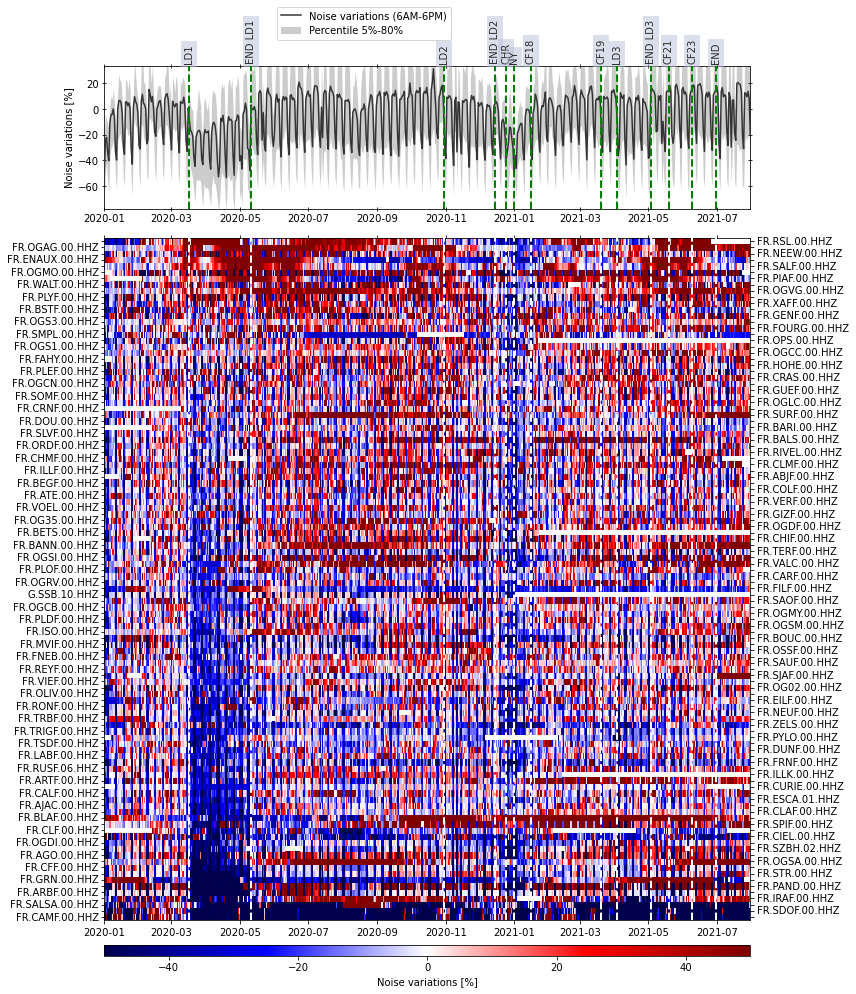

In [12]:
# Signal à afficher
signal_choice = "env_down" # "all", "env_up", "env_down"

# for signal_choice in ["all", "env_up", "env_down"]:
for signal_choice in ["all"]:

    if signal_choice == "all":
        filename_suffix = ""
        cbar_lim = (-50, 50)

    if signal_choice == "env_up":
        filename_suffix = "_envUP"
        cbar_lim = (-50, 50)

    if signal_choice == "env_down":
        filename_suffix = "_envDOWN"
        cbar_lim = (-50, 50)



    fig = plt.figure(figsize=(12, 15))
    grid = plt.GridSpec(30, 1)

    box_txt = dict(boxstyle="square",
                   facecolor='#B7C0D8',
                   edgecolor='none',
                   alpha=0.5)

    ### MEDIANE
    plt.subplot(grid[:5])
    plt.tick_params(direction="inout", which="both", top=True, right=True)
    plt.ylim(3.5 * np.quantile(noise_fr, 0.05), 5 * np.quantile(noise_fr, 0.95))
    plt.xlim([dates[0], dates[-1]])
    plt.ylabel("Noise variations [%]")
    plt.plot(dates, noise_fr, color=color, lw=1.5, zorder=3, label="Noise variations (6AM-6PM)")

    if signal_choice == "env_up":
        plt.plot(dates, enveloppe(dates, noise_fr)[1], color="#D32727", label="Upper Envelope", lw=1)
    if signal_choice == "env_down":
        plt.plot(dates[week_count['Sunday']], noise_fr[week_count['Sunday']], color="#D32727", label="Lower Envelope", lw=1)
        # plt.plot(dates, enveloppe(dates, noise_fr)[0], color="#D32727", label="Lower Envelope", lw=1)

    plt.fill_between(dates, perc_i, perc_f,alpha=.25, label="Percentile 5%-80%", color=color, lw=0)    
    plt.ylim(2*np.quantile(noise_fr, 0.05), 2*np.quantile(noise_fr, 0.95))
    plt.legend(loc=2, bbox_to_anchor=(0.26, 1.45))

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("0 days")
        plt.axvline(t_search, ls="--", lw=2, color="green", zorder=10)   # Confinement 1
        plt.text(t_text, 2.1*np.quantile(noise_fr, 0.95), desc_search,
                 color="#2B2B2B", fontsize="medium", rotation=90,
                 ha="center", va="bottom",
                 bbox=box_txt)   # Confinement 1


    ### PCOLORMESH
    plt.subplot(grid[5:])
    plt.tick_params(direction="out", which="both", top=True, right=True)
    if signal_choice == "all":      array2D = med_var
    if signal_choice == "env_up":   array2D = env_up_matrix
    if signal_choice == "env_down": array2D = env_down_matrix
    ref = np.nanmedian(np.array(med_var)[:,14:69], axis=1)
    l1  = np.nanmedian(np.array(med_var)[:,76:131], axis=1)
    varr = l1#-ref
    sort_list = varr.argsort()
    array2D_bis = [array2D[i] for i in sort_list]
    st_list_bis = [st_list_new[i] for i in sort_list]
    if signal_choice == "all":      plt.pcolormesh(dates, st_list_bis+[""], array2D_bis, cmap="seismic")
    if signal_choice == "env_up":   plt.pcolormesh(dates[week_count['Monday']], st_list_bis+[""], array2D_bis)
    if signal_choice == "env_down": plt.pcolormesh(dates[week_count['Sunday']], st_list_bis+[""], array2D_bis)
    plt.xlim([dates[0], dates[-1]])
    plt.tick_params(axis='y', labelsize=5)
    y_tick = np.arange(0, len(st_list_bis), 1) + 0.5
    plt.yticks(y_tick, st_list_bis*0)
    plt.ylim(0, len(st_list_bis))
    
    for i, txt in enumerate(st_list_bis):
        if i%2 == 0 : plt.text(dates[0]- pd.Timedelta("5 days"), 0.5+i, txt, ha='right', va='center', fontsize=10)
        else : plt.text(dates[-1]+ pd.Timedelta("6 days"), 0.5+i, txt, ha='left', va='center', fontsize=10)
        
    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("0 days")
        plt.axvline(t_search, ls="--", lw=2, color="white", zorder=10)   # Confinement 1

    plt.clim(cbar_lim)
    # plt.clim(np.quantile(array1D, 0.05), np.quantile(array1D, 0.95))
    plt.colorbar(orientation="horizontal", label='Noise variations [%]', pad=0.03, shrink=1, aspect=60)
    fig.tight_layout()

    folder = "RESULTS/FR/all_stations/{}Hz".format(freq_str)
    if not os.path.exists(folder): os.makedirs(folder)
    plt.savefig("{}/ts_day_details{}.png".format(folder, filename_suffix), dpi=150)

/!\

**Pour le colormesh du milieu : au lieu de prendre l'enveloppe inf/sup du premier subplot, faire le stack de toutes les enveloppes inf/sup du subplot 3 (je pense que ça réduit les trucs bizarres que fait l'enveloppe pour une courbe)**

---
## Médiane à toutes les stations par heure

In [13]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [14]:
h_list = [ "0:00", "1:00", "2:00", "3:00", "4:00", "5:00", "6:00", "7:00", "8:00", "9:00", "10:00",
           "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00",
           "21:00", "22:00", "23:00", "23:59"]

h_matrix = np.zeros((24, np.shape(med_var)[1]))

for k in tqdm.tqdm(range(len(h_list)-1)):

    med_values = []

    for j, st_str in enumerate(list_stations):
        # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

        ### Calcul du déplacement RMS de la station
        try:
            dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
            dataframe.index = pd.to_datetime(dataframe.index)
            dRMS = dataframe
            
            
            ### Conversion heures locales
            dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()

            ### On garde les données dans la période temporelle qui nous intéresse
            mask_time = (dRMS.index > tStart) & (dRMS.index <= tEnd)
            dRMS = dRMS.loc[mask_time]

            ### Récupération du bruit
            dRMS_med = dRMS[freq].between_time(h_list[k], h_list[k+1]).resample("1D").median()
            dRMS_med = dfDates.join(dRMS_med, how='outer')

            ### Normalisation du bruit
            dRMS_med = dRMS_med[freq].tolist()
            norm = np.nanmedian(dRMS_med)
            dRMS_med = dRMS_med/norm
            if len(dRMS_med) > len(dates):
                dRMS_med = dRMS_med[:len(dates)]
                
        except:
            continue
            
        # print(len(dRMS_med))
        
        med_values.append(dRMS_med)

    noise_fr = np.zeros(nDays)

    for i in range(nDays):

        sublist = list()

        for j in range(np.shape(med_values)[0]):
            sublist.append(med_values[j][i])

        noise_fr[i] = np.nanmedian(sublist)

    norm_period = ["2020-01-15", "2020-03-10"]
    t1_i = np.where(dates >= pd.Timestamp(norm_period[0]))[0][0]
    t2_i = np.where(dates >= pd.Timestamp(norm_period[1]))[0][0]
    noise_med = np.nanmedian(noise_fr)
    noise_fr = (noise_fr - noise_med)/noise_med*100

    color = "#353535"
    # fig, ax = plt.subplots(figsize=(12, 5))
    # ax.tick_params(direction="in", which="both", top=True, right=True)
    # ax.plot(dates, noise_fr, color=color, lw=2, zorder=3, label="Noise variations at {}h".format(h_mid[k]))
    # plt.ylim(3*np.quantile(noise_fr, 0.05), 3*np.quantile(noise_fr, 0.95))
    # ax.set_xlim([dates[0], dates[-1]])
    # ax.set_ylabel("Noise level variations [%]")

#     box_txt = dict(boxstyle="square",
#                facecolor='#B7C0D8',
#                edgecolor='none',
#                alpha=0.5)

#     for n in range(len(dates_tags)):
#         t_search = dates_tags[n]
#         desc_search = desc_tags[n]
#         t_text = t_search - pd.Timedelta("5 days")
#         ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
#         ax.text(t_text, 2.9*np.quantile(noise_fr, 0.05), desc_search,
#                 color="#2B2B2B", fontsize="medium", rotation=90,
#                 ha="center", va="bottom",
#                 bbox=box_txt)   # Confinement 1

    h_matrix[k][:] = noise_fr
    
    med_var = np.zeros(np.shape(med_values))

    for i in range(np.shape(med_var)[0]):
        sub_list = med_values[i][:] 
        try:
            med_var[i][:] = (sub_list - np.nanmedian(sub_list))/np.nanmedian(sub_list) * 100
        except:
            med_var[i][:] = sub_list
    
    perc_i = list()  # 5%
    perc_f = list()  # 80%

    for ii in range(np.shape(med_var)[1]):
        sublist = list()
        for i in range(np.shape(med_var)[0]):
            sublist = np.append(sublist, med_var[i][ii])

        perc_i = np.append(perc_i, np.nanquantile(sublist, 0.05))
        perc_f = np.append(perc_f, np.nanquantile(sublist, 0.8))
        
#     plt.fill_between(dates, perc_i, perc_f,alpha=.25, label="Percentile 5%-80%", color=color, lw=0)
        
#     plt.grid(color="#D5D5D5", linestyle='--', linewidth=1)
#     plt.legend(loc=2)
#     plt.title("{} Hz".format(freq_str))
#     plt.tight_layout()
    
#     folder = "RESULTS/FR/all_stations/{}Hz".format(freq_str)
#     if not os.path.exists(folder): os.makedirs(folder)
#     plt.savefig("{}/ts_{}h.png".format(folder, h_mid[k]), dpi=150)
    
#     plt.clf()
#     plt.close()

  0%|                                                                                            | 0/24 [00:00<?, ?it/s]/home/flavien/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [03:55<00:00,  9.82s/it]


/tmp/ipykernel_31109/499540133.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(dates, h_mid, h_matrix, cmap='seismic')


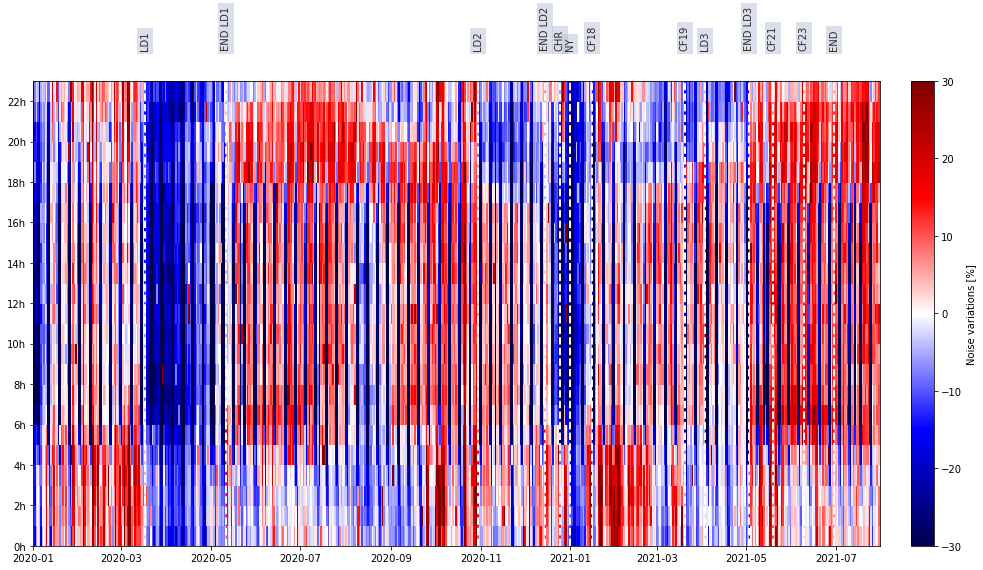

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
h_mid = np.arange(0, 24, 1)
plt.pcolormesh(dates, h_mid, h_matrix, cmap='seismic')

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("0 days")
    plt.axvline(t_search, ls="--", lw=2, color="white", zorder=10)   # Confinement 1
    plt.text(t_text, 24.5, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1
    
h_label = ["0h","2h","4h","6h","8h","10h","12h","14h","16h","18h","20h","22h"]
plt.yticks(np.arange(0, 24, 2), h_label)
# plt.clim(np.quantile(h_matrix, 0.1), np.quantile(h_matrix, 0.97))
plt.clim(-30, 30)
plt.colorbar(orientation="vertical", label='Noise variations [%]', pad=0.03)
plt.tight_layout()
folder = "RESULTS/FR/all_stations/{}Hz".format(freq_str)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/ts_hourvar.png".format(folder), dpi=150)

/!\ Pour l'interprétation de ce graphe, chaque ligne (i.e. chaque heure) indique les variations par rapport au niveau de bruit médian de l'heure en question. COmment chaque heure n'a pas le même niveau de référence, l'interprétation est plus délicate (e.g. le niveau de bruit est pas plus fort le soir en été)
==> peut-être recalibrer ce graphe avec une même référence pour toutes les lignes !!

/tmp/ipykernel_31109/1185768948.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(dates[week_count[week_name]], h_mid, h_matrix_bis, cmap="seismic")


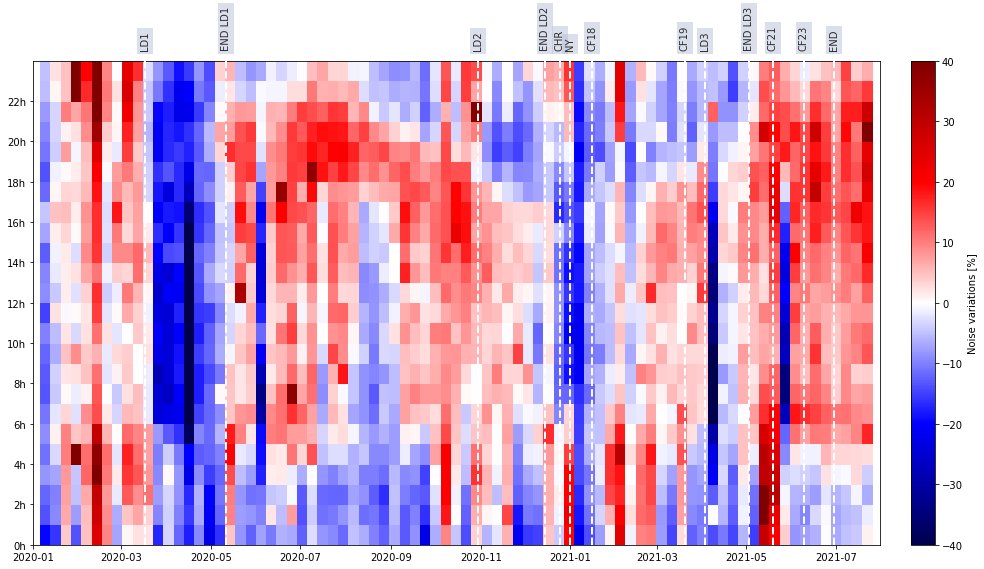

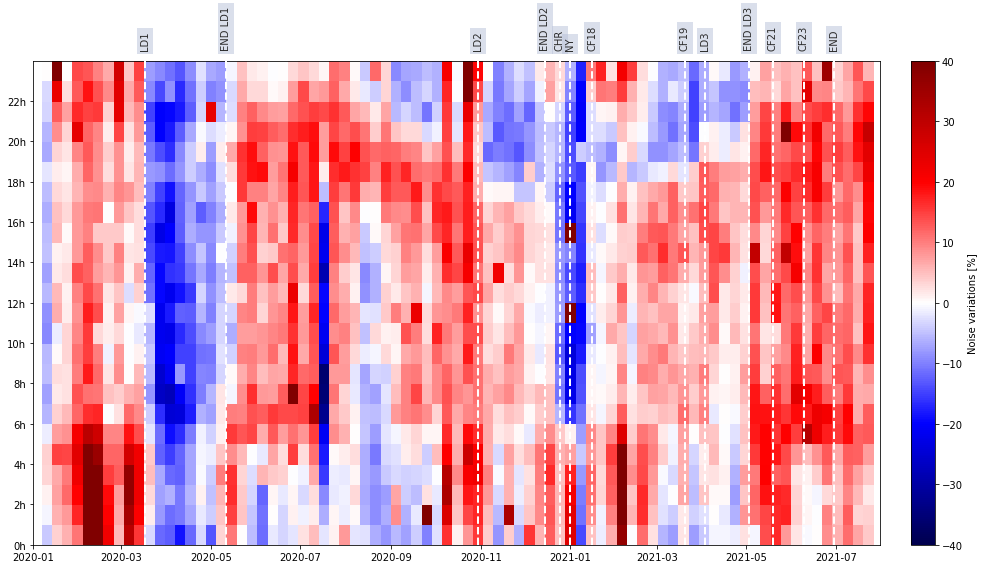

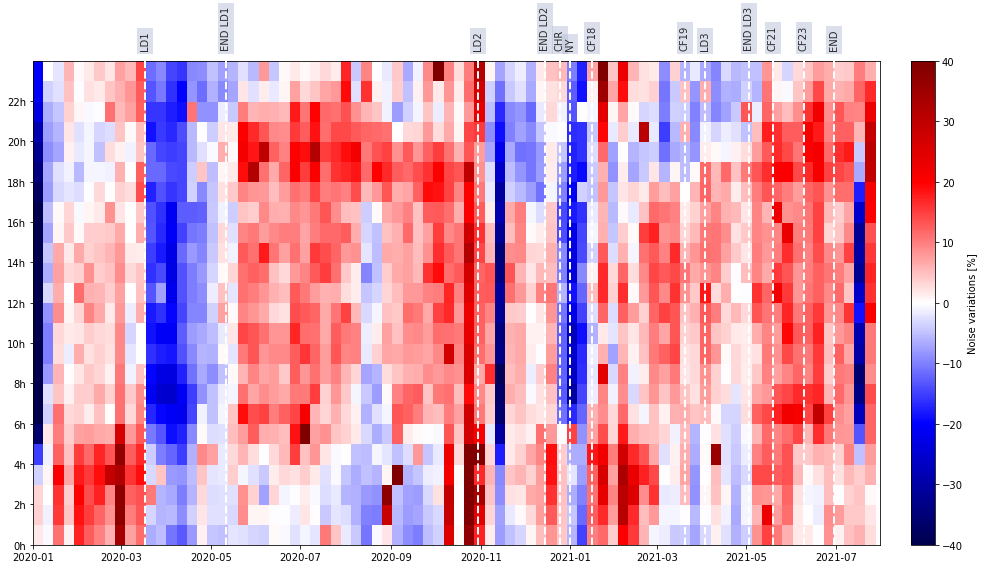

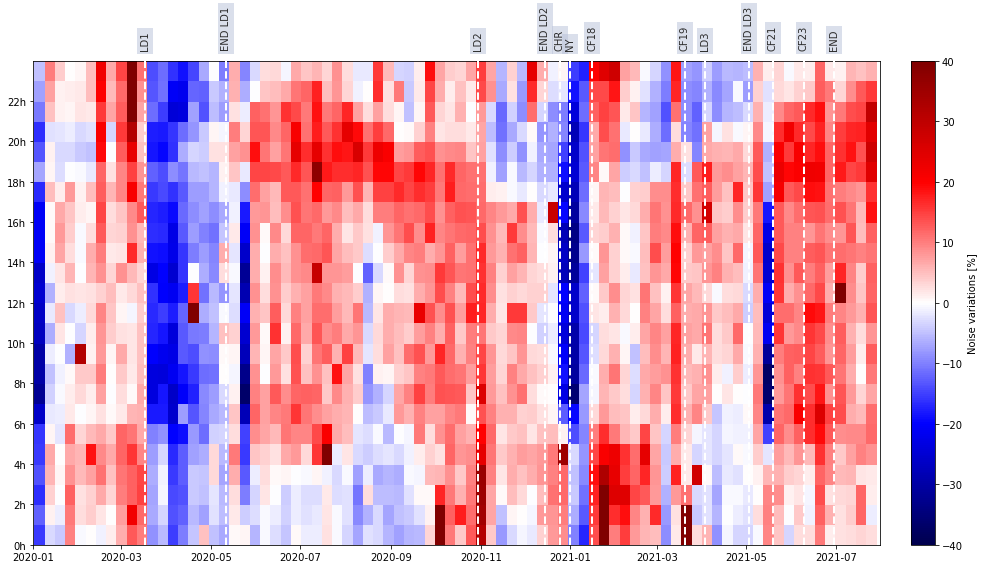

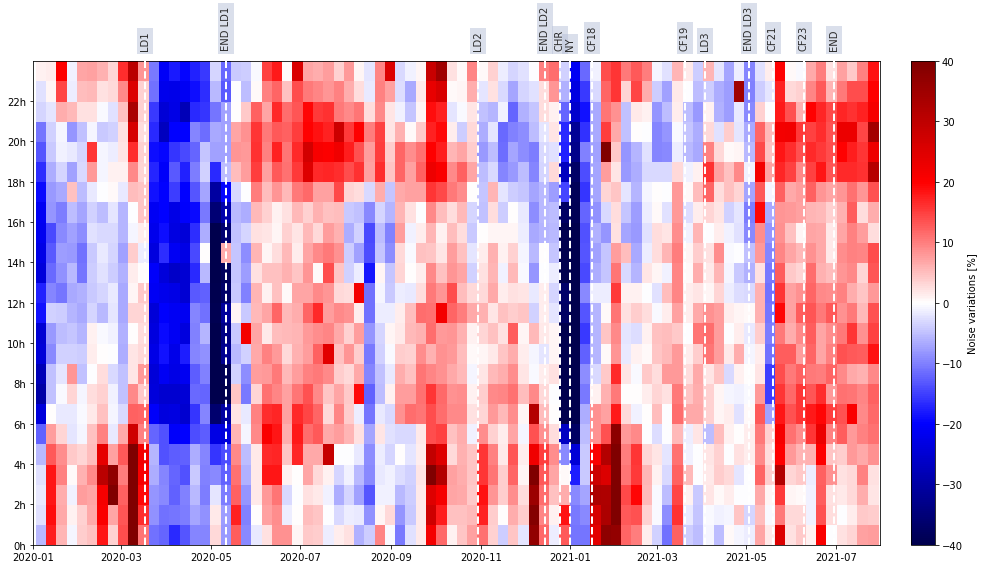

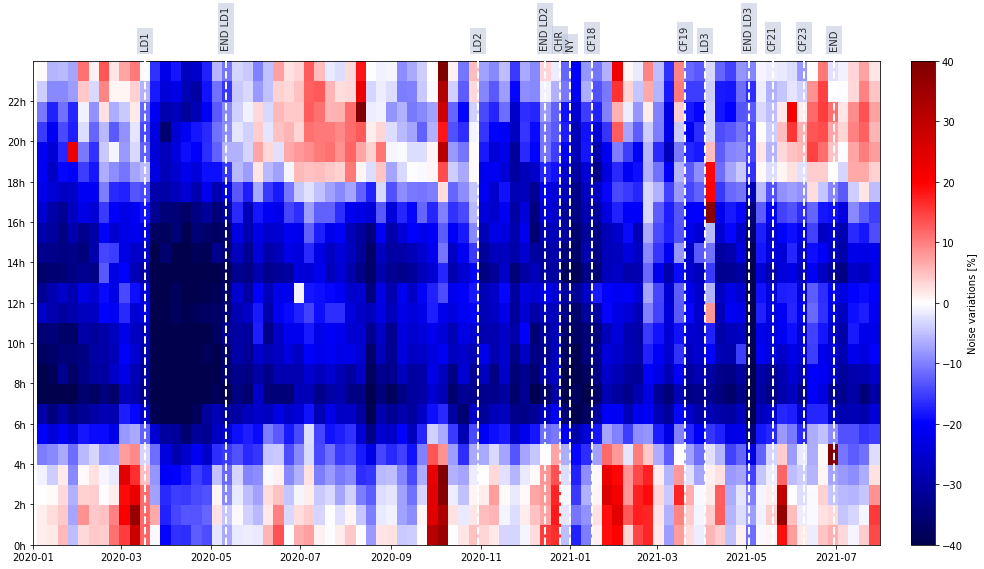

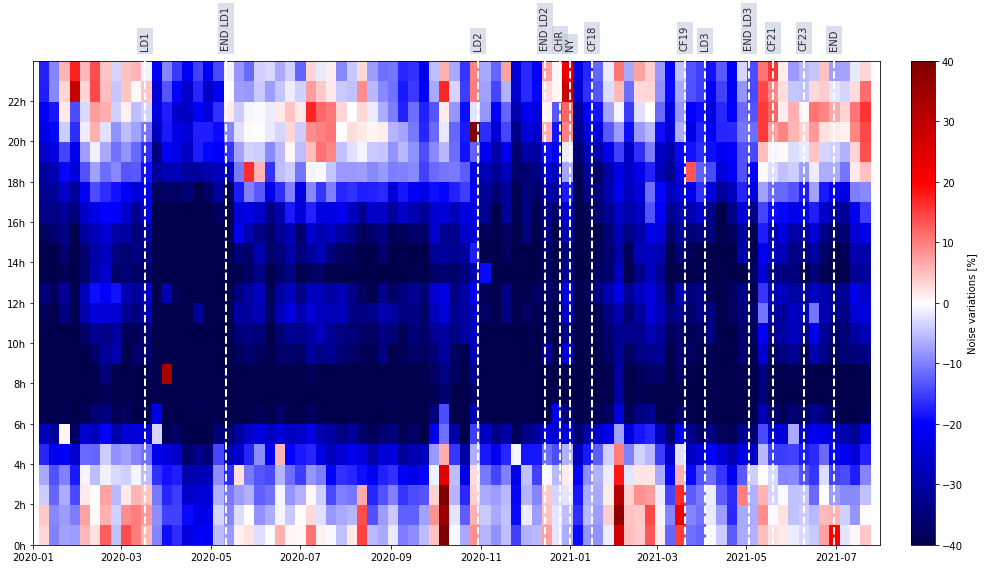

In [16]:
for week_name in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
    fig, ax = plt.subplots(figsize=(15, 8))
    h_mid = np.arange(0, 25, 1)

    h_matrix_bis = np.zeros((24, len(week_count[week_name])))
    for i in range(np.shape(h_matrix)[0]):
        sublist = h_matrix[i][:]
        h_matrix_bis[i][:] = sublist[week_count[week_name]]

    plt.pcolormesh(dates[week_count[week_name]], h_mid, h_matrix_bis, cmap="seismic")

    box_txt = dict(boxstyle="square",
                   facecolor='#B7C0D8',
                   edgecolor='none',
                   alpha=0.5)

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("0 days")
        plt.axvline(t_search, ls="--", lw=2, color="white", zorder=10)   # Confinement 1
        plt.text(t_text, 24.5, desc_search,
                color="#2B2B2B", fontsize="medium", rotation=90,
                ha="center", va="bottom",
                bbox=box_txt)   # Confinement 1

    h_label = ["0h","2h","4h","6h","8h","10h","12h","14h","16h","18h","20h","22h"]
    plt.xlim(dates[0], dates[-1])
    plt.yticks(np.arange(0, 24, 2), h_label)
    # plt.clim(np.quantile(h_matrix_bis, 0.1), np.quantile(h_matrix_bis, 0.97))
    plt.clim(-40, 40)
    plt.colorbar(orientation="vertical", label='Noise variations [%]', pad=0.03)
    plt.tight_layout()
    folder = "RESULTS/FR/all_stations/{}Hz".format(freq_str)
    if not os.path.exists(folder): os.makedirs(folder)
    plt.savefig("{}/ts_hourvar_{}.png".format(folder, week_name), dpi=150)
    plt.show()

---
## Comparaison horaire et journalière

In [17]:
nlines = 2
ncols  = 4
periods = {
    'BEFORE LOCKDOWN 1':(pd.to_datetime("2020-01-15"), pd.to_datetime("2020-03-10")),
    'LOCKDOWN 1':(pd.to_datetime("2020-03-17"), pd.to_datetime("2020-05-11")),
    'LOCKDOWN 2':(pd.to_datetime("2020-10-30"), pd.to_datetime("2020-12-15")),
    'LOCKDOWN 3':(pd.to_datetime("2021-04-03"), pd.to_datetime("2021-05-03")),
    'CURFEW 18h':(pd.to_datetime("2021-01-16"), pd.to_datetime("2021-03-20")),
    'CURFEW 21h':(pd.to_datetime("2021-05-19"), pd.to_datetime("2021-06-09")),
    'CURFEW 23h':(pd.to_datetime("2021-06-09"), pd.to_datetime("2021-06-30")),
    'END CURFEW':(pd.to_datetime("2021-06-30"), pd.to_datetime("2021-07-30"))
}

plt.figure(figsize=(4*ncols, 4*nlines))

ss = 1
for desc in periods.keys():
    plt.subplot(nlines, ncols, ss)
    
    plt.tick_params(direction="inout", which="both", top=True, right=True)

    t1 = periods[desc][0]
    t2 = periods[desc][1]

    for weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:

        dates_sort = dates[week_count[weekday]]
        dates_sort = dates_sort[dates_sort >= t1]
        dates_sort = dates_sort[dates_sort <= t2]

        k=0
        for d in dates_sort:
            ii = np.where(dates == d)[0][0]
            if k==0: subarray = np.array(h_matrix[:,ii])
            else:    subarray = np.vstack([subarray, h_matrix[:,ii]])
            k += 1

        subarray = np.nanmedian(subarray, axis=0)
        subarray = np.expand_dims(subarray, 1)

        if weekday=='Monday': week_array = subarray
        else:                 week_array = np.append(week_array, subarray, axis=1)
    
    plt.title("{}\n{} to {}".format(desc, t1.strftime('%Y-%m-%d'), t2.strftime('%Y-%m-%d')), loc="left", fontweight="bold", fontsize=10)
    plt.pcolormesh(week_array)
    h_label = ["2h","6h","10h","14h","18h","22h"]
    w_label = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
    plt.yticks(np.arange(2, 24, 4)+0.5, h_label)
    plt.xticks(np.arange(0, 7, 1)+0.5, w_label)
    plt.clim(-50, 20)
    
    ss += 1
    
plt.tight_layout()
plt.close()
# plt.show()

In [18]:
df = pd.DataFrame(columns=[freq], index=pd.date_range(tStart, tEnd, freq="30min"))

dRMS_array = []

for j, st_str in tqdm.tqdm(enumerate(list_stations)):
    # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index = pd.to_datetime(dataframe.index)
        dRMS = dataframe.copy()
    except:
        continue
       
    ### Conversion heures locales
    dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()
    dRMS_new = pd.merge(df,dRMS, how='left', left_index=True, right_index=True)["{}_y".format(freq)]
    dRMS_new = (dRMS_new-np.nanmedian(dRMS_new))/np.nanmedian(dRMS_new) * 100
    
    if len(dRMS_array) == 0: dRMS_array = np.array(dRMS_new)
    else:                    dRMS_array = np.vstack([dRMS_array, dRMS_new])
    
    
    

147it [00:08, 16.41it/s]


In [19]:
noise = np.nanmedian(dRMS_array, axis=0)
time = pd.date_range(tStart, tEnd, freq="30min")
noise = pd.Series(noise, index=time)

In [20]:
time, hour, noise_matrix = hourly_var(noise, [[UTCDateTime(tStart), UTCDateTime(tEnd)]])
grid = noise_matrix  # Données en [nm]

In [21]:
### Mise en graphique de la variation du bruit
plt.figure(figsize=(16, 8))
plt.pcolormesh(time, hour+0.25, grid)
plt.clim(np.nanquantile(grid, 0.05), np.nanquantile(grid, 0.95))
plt.colorbar(label="Déplacement [nm]")

### Configuration de l'axe vertical
plt.ylabel("Heure locale")
y_ticks = ["%ih" % j for j in range(1, 24)]
y_loc = [j for j in range(1, 24)]
plt.yticks(y_loc, y_ticks)
# plt.show()
plt.close()

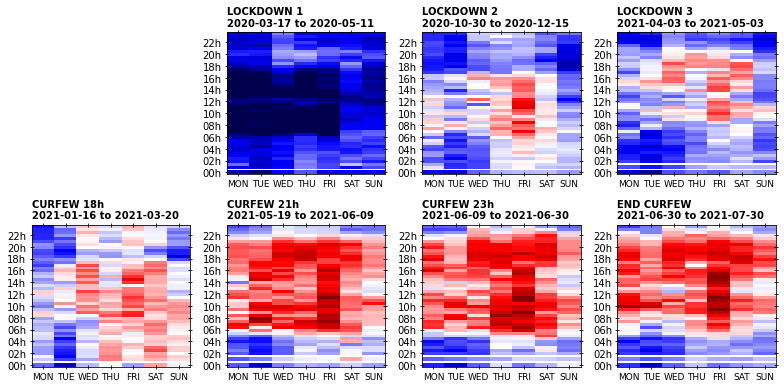

In [22]:
h_matrix = grid

nlines = 2
ncols  = 4
periods = {
    'BEFORE LOCKDOWN 1':(pd.to_datetime("2020-01-15"), pd.to_datetime("2020-03-10")),
    'LOCKDOWN 1':(pd.to_datetime("2020-03-17"), pd.to_datetime("2020-05-11")),
    'LOCKDOWN 2':(pd.to_datetime("2020-10-30"), pd.to_datetime("2020-12-15")),
    'LOCKDOWN 3':(pd.to_datetime("2021-04-03"), pd.to_datetime("2021-05-03")),
    'CURFEW 18h':(pd.to_datetime("2021-01-16"), pd.to_datetime("2021-03-20")),
    'CURFEW 21h':(pd.to_datetime("2021-05-19"), pd.to_datetime("2021-06-09")),
    'CURFEW 23h':(pd.to_datetime("2021-06-09"), pd.to_datetime("2021-06-30")),
    'END CURFEW':(pd.to_datetime("2021-06-30"), pd.to_datetime("2021-07-30"))
}

plt.figure(figsize=(2.75*ncols, 2.75*nlines))

ss = 1
for desc in periods.keys():
    if ss == 1: plt.subplot(nlines, ncols, 2)
    else      : plt.subplot(nlines, ncols, ss)
    
    plt.tick_params(direction="inout", which="both", top=True, right=True)

    t1 = periods[desc][0]
    t2 = periods[desc][1]

    for weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:

        dates_sort = dates[week_count[weekday]]
        dates_sort = dates_sort[dates_sort >= t1]
        dates_sort = dates_sort[dates_sort <= t2]

        k=0
        for d in dates_sort:
            ii = np.where(dates == d)[0][0]
            if k==0: subarray = np.array(h_matrix[:,ii])
            else:    subarray = np.vstack([subarray, h_matrix[:,ii]])
            k += 1

        subarray = np.nanmedian(subarray, axis=0)
        subarray = np.expand_dims(subarray, 1)

        if weekday=='Monday': week_array = subarray
        else:                 week_array = np.append(week_array, subarray, axis=1)
        
    if desc == "BEFORE LOCKDOWN 1": week_array_ref = week_array
        
    week_array = week_array-week_array_ref
    
    plt.title("{}\n{} to {}".format(desc, t1.strftime('%Y-%m-%d'), t2.strftime('%Y-%m-%d')), loc="left", fontweight="bold", fontsize=10)
    plt.pcolormesh(week_array, cmap="seismic")
    h_label = ["{:02d}h".format(j) for j in np.arange(0, 24, 2)]
    w_label = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
    plt.yticks(np.arange(0, 48, 4)+0.5, h_label)
    plt.xticks(np.arange(0, 7, 1)+0.5, w_label, fontsize=9)
    plt.clim(-30, 30)
    
    ss += 1
    
plt.tight_layout()
folder = "RESULTS/FR/all_stations/{}Hz".format(freq_str)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/hours_vs_week_periods.png".format(folder), dpi=150)
plt.show()